The following are implemented as part of this homework-Image Segmentation by applying K-Means.

* Used sklearn K-means to segment images and visualize results for a training set of 250 samples
* Used HOG to improve results
* Calculated Intersection over Union (IoU) for the result of using and not using features.

In [1]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

Reading files through xml Annotation

In [2]:
def read_xml_files(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        boundary = obj.find('bndbox')
        xmin = int(boundary.find('xmin').text)
        ymin = int(boundary.find('ymin').text)
        xmax = int(boundary.find('xmax').text)
        ymax = int(boundary.find('ymax').text)

        print(f"Class: {obj_name}, Bounding Box: ({xmin}, {ymin}, {xmax}, {ymax})")

        return xmin, ymin, xmax - xmin, ymax - ymin  

folder_path = '/Users/harshita/Documents/UTA/PatternRecognition/VOCdevkit/VOC2012'
xml = '2012_000003.xml'
xml_fPath = os.path.join(folder_path, 'Annotations', xml)

boundary_ground_truth = read_xml_files(xml_fPath)


Class: person, Bounding Box: (151, 103, 389, 356)


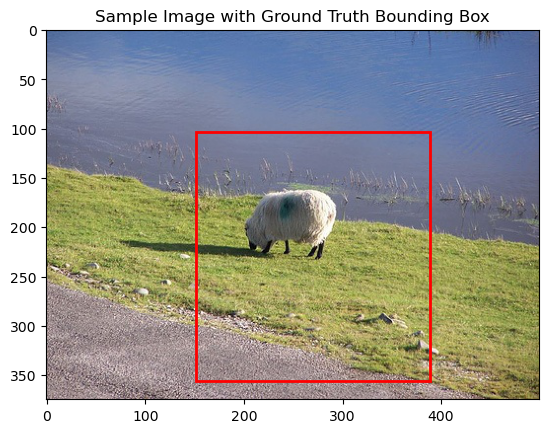

In [3]:

# Load image
image_file_path = os.path.join(folder_path, 'JPEGImages', '2007_004969.jpg')
image = cv2.imread(image_file_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Sample Image with Ground Truth Bounding Box')
x, y, w, h = boundary_ground_truth
plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
plt.show()

Extracting features with FOG

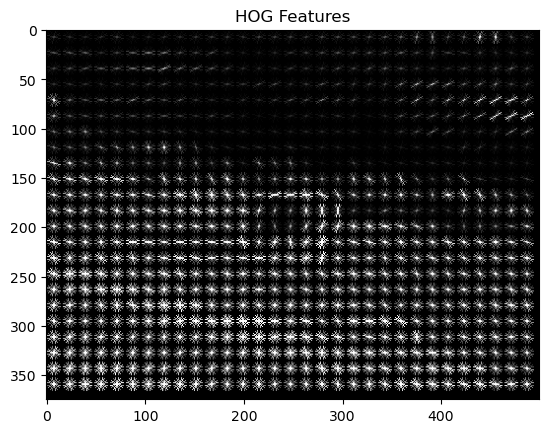

In [7]:
import cv2
from skimage.feature import hog
from skimage import exposure

def hog_extraction(image):
    g_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    features, h_img = hog(g_img, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), visualize=True)

    h_i_rscaled = exposure.rescale_intensity(h_img, in_range=(0, 10))

    return h_i_rscaled


# Example usage
h_f = hog_extraction(image_rgb)

# Display HOG features
plt.imshow(h_f, cmap='gray')
plt.title('HOG Features')
plt.show()


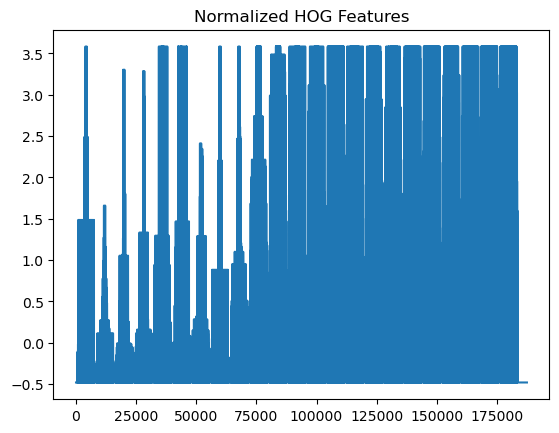

In [8]:
def reshape_hog(h_f):
    f_hog = h_f.flatten()
    normalized_features = (f_hog - np.mean(f_hog)) / np.std(f_hog)
    return normalized_features

# Flatten and normalize HOG features
n_hog = reshape_hog(h_f)

plt.plot(n_hog)
plt.title('Normalized HOG Features')
plt.show()

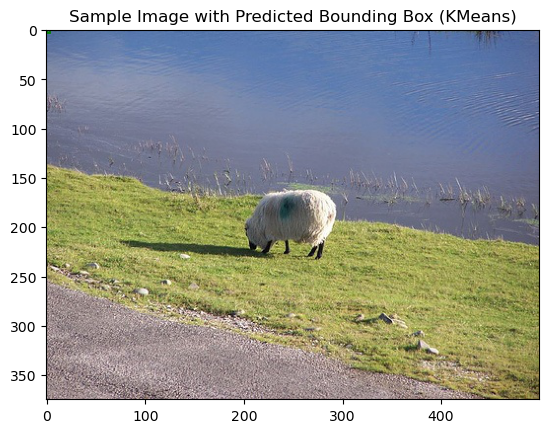

In [9]:
def predict_boundingbox(features, k=9):
    kmeans = KMeans(n_clusters=k, random_state=0)
    lbl = kmeans.fit_predict(features.reshape(-1, 1))
    boundary = (np.min(lbl), np.min(lbl), np.max(lbl), np.max(lbl))
    return boundary

boundary_kmeans = predict_boundingbox(n_hog, k=3)



# Display predicted bounding box
plt.imshow(image_rgb)
plt.title('Sample Image with Predicted Bounding Box (KMeans)')
x_kmeans, y_kmeans, w_kmeans, h_kmeans = boundary_kmeans
plt.gca().add_patch(plt.Rectangle((x_kmeans, y_kmeans), w_kmeans, h_kmeans, linewidth=2, edgecolor='g', facecolor='none'))
plt.show()

In [14]:
from sklearn.cluster import KMeans
import numpy as np

def kmeans_image_segment(image, n_clusters=9):
    # Normalize pixel values
    img_val = image.reshape((-1, 3))
    img_val = np.float32(img_val) / 255.0  

    # Applying KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = kmeans.fit_predict(img_val)

    # Convert back to the original image shape
    km_labels = km_labels.reshape((image.shape[0], image.shape[1]))

    # Create segmented image
    seg_img = np.zeros_like(image, dtype=np.uint8)
    for i in range(n_clusters):
        seg_img[km_labels == i] = np.uint8(kmeans.cluster_centers_[i]*2)

    return seg_img


In [10]:
def calculate_iou(seg, gt):
    # Convert images to binary masks
    segb = (seg > 0)
    gtb = (gt > 0)

    # Ensure both masks have the same dimensions
    min_height = min(segb.shape[0], gtb.shape[0])
    min_width = min(segb.shape[1], gtb.shape[1])

    segb = cv2.resize(segb.astype(np.uint8), (min_width, min_height))
    gtb = cv2.resize(gtb.astype(np.uint8), (min_width, min_height))

    # Calculate intersection and union
    intersection = np.logical_and(segb, gtb)
    union = np.logical_or(segb, gtb)

    # Calculate IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


In [16]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

bp = '/Users/harshita/Documents/UTA/PatternRecognition/VOCdevkit/VOC2012'

# Define the paths to image and mask folders
imgf = os.path.join(bp, 'JPEGImages')
smf = os.path.join(bp, 'Annotations')

# Process a random subset of 250 images and calculate IoU for both cases
hog_s = []
km_s = []

# Get a random subset of 250 images
random_f = random.sample(os.listdir(imgf), 250)

for fname in random_f:
    if fname.endswith(".jpg"):
        image_path = os.path.join(imgf, fname)
        xml_path = os.path.join(smf, fname.replace('.jpg', '.xml'))

        if os.path.exists(xml_path):
            # Load the image and ground truth mask
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gt = read_xml_files(xml_path)

            # Extract HOG features
            hog_features = hog_extraction(image)

            # Apply k-means clustering to HOG features
            flattened_features = hog_features.flatten().reshape((-1, 1))
            kmeans_hog = KMeans(n_clusters=9, random_state=35).fit(flattened_features)
            segmented_image_hog = kmeans_hog.labels_.reshape(hog_features.shape)

            # Binarize the segmented image and ground truth for IoU calculation
            _, bin_seg = cv2.threshold(segmented_image_hog.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)
            _, binary_gt = cv2.threshold(gt, 0, 255, cv2.THRESH_BINARY)

            # Calculate IoU for HOG method
            iou_score_hog = calculate_iou(bin_seg, binary_gt)
            hog_s.append(iou_score_hog)

            # Apply k-means clustering directly to image
            kmeans_segmented_image = kmeans_image_segment(image, n_clusters=9)

            # Binarize the segmented image and ground truth for IoU calculation
            _, bin_km = cv2.threshold(kmeans_segmented_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)
            iou_score_kmeans = calculate_iou(bin_km, binary_gt)
            km_s.append(iou_score_kmeans)

#             # Visualize segmented image for debugging
#             plt.imshow(binary_segmentation_kmeans, cmap='gray')
#             plt.title('Segmented Image')
#             plt.show()
            

# Calculate average IoU for HOG method
average_iou_hog = sum(hog_s) / len(hog_s)
print(f"Average IoU Score (HOG): {average_iou_hog}")

# Calculate average IoU for KMeans method
average_iou_kmeans = sum(km_s) / len(km_s)
print(f"Average IoU Score (KMeans): {average_iou_kmeans}")


Class: dog, Bounding Box: (89, 18, 458, 369)
Class: chair, Bounding Box: (121, 340, 246, 500)
Class: dog, Bounding Box: (122, 11, 336, 223)
Class: person, Bounding Box: (149, 1, 500, 375)
Class: horse, Bounding Box: (124, 152, 455, 351)
Class: sofa, Bounding Box: (1, 46, 196, 191)
Class: cat, Bounding Box: (324, 122, 387, 267)
Class: person, Bounding Box: (336, 1, 463, 201)
Class: cat, Bounding Box: (1, 16, 500, 332)
Class: diningtable, Bounding Box: (1, 297, 500, 375)
Class: person, Bounding Box: (197, 78, 289, 301)
Class: sofa, Bounding Box: (321, 130, 499, 346)
Class: person, Bounding Box: (356, 166, 441, 341)
Class: horse, Bounding Box: (37, 1, 314, 384)
Class: boat, Bounding Box: (27, 22, 337, 429)
Class: train, Bounding Box: (119, 108, 396, 295)
Class: bird, Bounding Box: (130, 77, 474, 232)
Class: aeroplane, Bounding Box: (66, 18, 423, 155)
Class: chair, Bounding Box: (219, 3, 375, 500)
Class: person, Bounding Box: (1, 157, 160, 500)
Class: car, Bounding Box: (356, 193, 368, 201

Class: person, Bounding Box: (193, 192, 375, 430)
Class: person, Bounding Box: (115, 101, 240, 364)
Class: aeroplane, Bounding Box: (66, 62, 500, 224)
Class: tvmonitor, Bounding Box: (226, 117, 401, 299)
Class: sheep, Bounding Box: (1, 104, 291, 399)
Class: person, Bounding Box: (116, 19, 259, 482)
Class: person, Bounding Box: (234, 152, 301, 289)
Class: boat, Bounding Box: (1, 27, 450, 282)
Class: train, Bounding Box: (22, 62, 500, 291)
Class: car, Bounding Box: (1, 1, 497, 373)
Class: car, Bounding Box: (218, 381, 375, 500)
Class: person, Bounding Box: (1, 42, 202, 375)
Class: cat, Bounding Box: (1, 42, 407, 394)
Class: person, Bounding Box: (68, 177, 208, 307)
Class: cat, Bounding Box: (33, 74, 256, 371)
Class: person, Bounding Box: (75, 19, 324, 482)
Class: bottle, Bounding Box: (104, 74, 196, 120)
Class: cat, Bounding Box: (162, 1, 410, 375)
Class: person, Bounding Box: (109, 59, 200, 277)
Class: person, Bounding Box: (359, 75, 468, 330)
Class: person, Bounding Box: (75, 95, 396, 

**Visualizing random 20 images from the subset of 250 trained images.**

Class: person, Bounding Box: (52, 34, 259, 443)
Class: dog, Bounding Box: (259, 162, 367, 244)
Class: person, Bounding Box: (72, 94, 367, 500)
Class: person, Bounding Box: (61, 54, 217, 300)
Class: cat, Bounding Box: (160, 1, 448, 375)
Class: aeroplane, Bounding Box: (161, 110, 336, 159)
Class: bicycle, Bounding Box: (1, 1, 395, 334)
Class: cow, Bounding Box: (118, 306, 155, 337)
Class: car, Bounding Box: (1, 1, 497, 373)
Class: person, Bounding Box: (174, 314, 225, 436)
Class: person, Bounding Box: (271, 42, 450, 333)
Class: sheep, Bounding Box: (71, 122, 161, 207)
Class: dog, Bounding Box: (24, 108, 292, 460)
Class: person, Bounding Box: (1, 157, 160, 500)
Class: bus, Bounding Box: (156, 360, 238, 460)
Class: tvmonitor, Bounding Box: (309, 14, 500, 253)
Class: person, Bounding Box: (217, 80, 305, 304)
Class: chair, Bounding Box: (404, 160, 493, 314)
Class: chair, Bounding Box: (192, 282, 399, 375)
Class: sheep, Bounding Box: (1, 104, 291, 399)


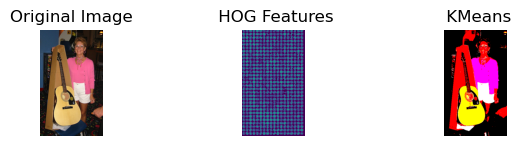

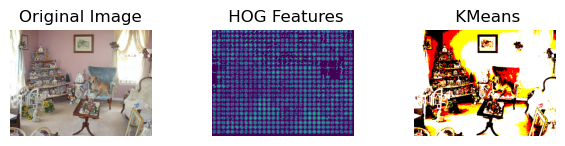

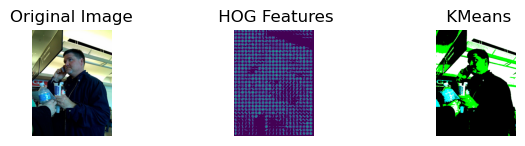

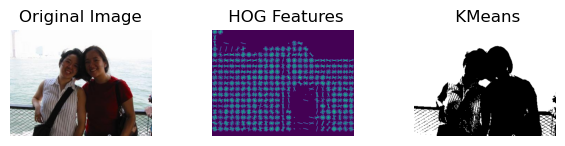

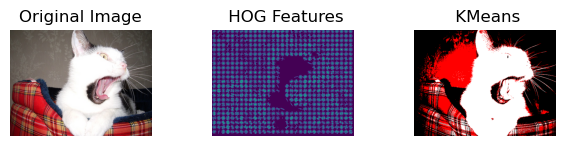

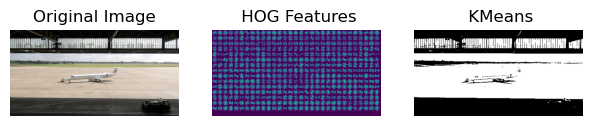

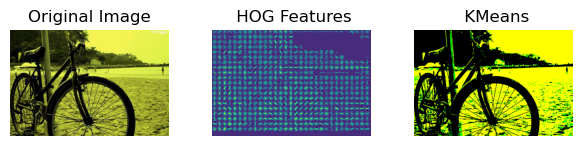

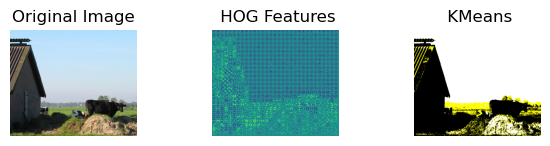

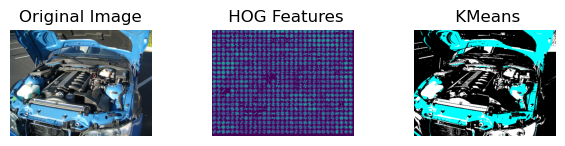

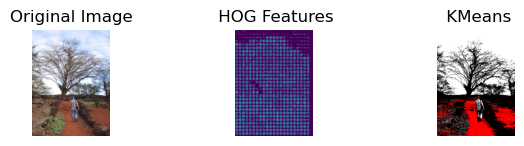

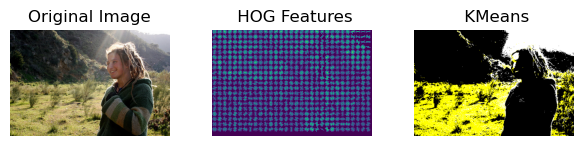

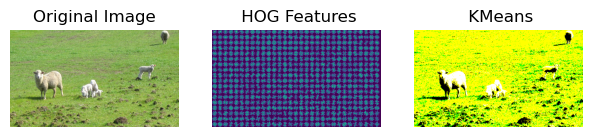

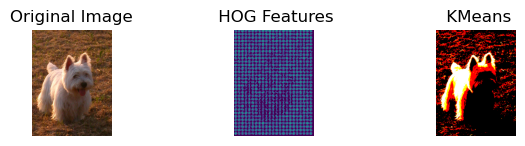

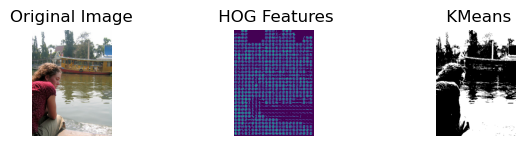

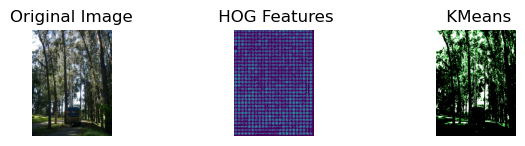

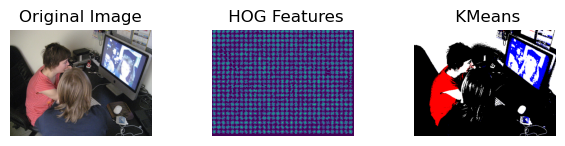

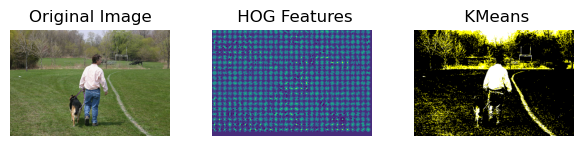

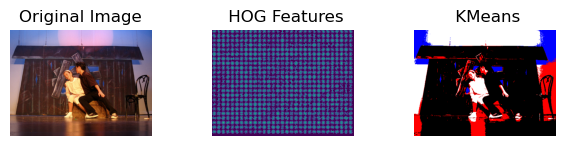

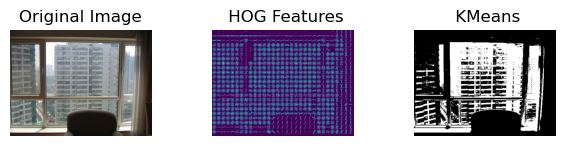

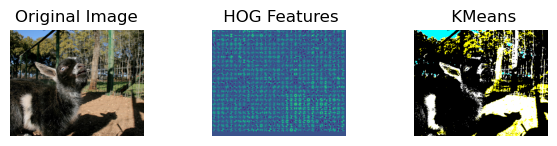

In [21]:
# Visualize random 20 images from the subset


for i in range(20):
    r_fname = random.choice(random_f)
    r_ip = os.path.join(imgf, r_fname)
    random_xml_path = os.path.join(smf, r_fname.replace('.jpg', '.xml'))

    if os.path.exists(random_xml_path):
        r_img = cv2.imread(r_ip)
        r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB)
        random_gt = read_xml_files(random_xml_path)


        # Extract HOG features 
        random_h_f= hog_extraction(r_img)

        # Apply k-means clustering to HOG features
        flattened_features = random_h_f.flatten().reshape((-1, 1))
        kmeans_hog = KMeans(n_clusters=9, random_state=0).fit(flattened_features)
        segmented_image_hog = kmeans_hog.labels_.reshape(random_h_f.shape)

        # Apply k-means clustering directly to image
        kmeans_segmented_image = kmeans_image_segment(r_img, n_clusters=9)

        # Binarize the segmented image for IoU calculation
        _, binary_segmentation_kmeans = cv2.threshold(kmeans_segmented_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)

        plt.figure(figsize=(10, 8))
    
        

        # Plot original image
        plt.subplot(5, 4, 1)
        plt.imshow(r_img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Plot segmentation with HOG features
        plt.subplot(5, 4, 2)
        plt.imshow(segmented_image_hog, cmap='viridis')
        plt.title(' HOG Features')
        plt.axis('off')

        # Plot segmentation with KMeans
        plt.subplot(5, 4, 3)  # Changed the index to 3
        plt.imshow(binary_segmentation_kmeans, cmap='viridis')
        plt.title(' KMeans')
        plt.axis('off')




plt.show()


Using HOG features has better  accuracy.


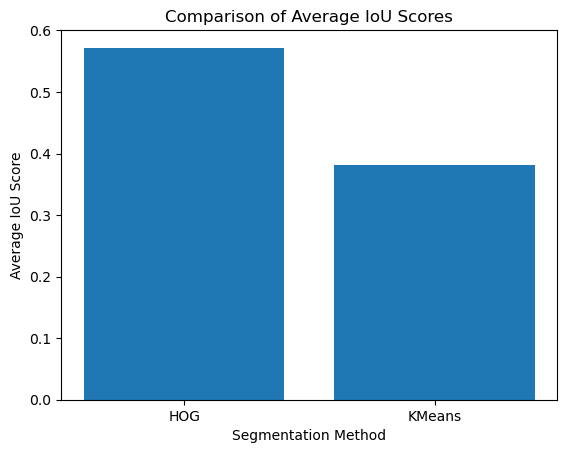

In [22]:
# Compare IoU scores and discuss the results
if average_iou_hog > average_iou_kmeans:
    print("Using HOG features has better  accuracy.")
elif average_iou_hog < average_iou_kmeans:
    print("without feature extraction using HOG image pixels has more segmentation accuracy.")
else:
    print("There is no significant difference in segmentation accuracy between HOG and KMeans methods.")

# Display the comparison of IoU scores
plt.bar(['HOG', 'KMeans'], [average_iou_hog, average_iou_kmeans])
plt.xlabel('Segmentation Method')
plt.ylabel('Average IoU Score')
plt.title('Comparison of Average IoU Scores')
plt.show()


**Analysis:**
Image Segmentation by using KMeans and for feature extraction HOG is used.after performing feature extraction, the IoU score has improved a bit.This could be due to 
- KMeans clustering segmented the image based on pixel-level similarity.
- HOG feature extraction captured semantically meaningful features related to object shapes and structures.
- HOG provided local gradient information about edges and textures, aiding in better discrimination between objects and background.
- Integration of HOG features with KMeans improved the model's ability to delineate object boundaries accurately.
- The improvement in IoU score suggested enhanced segmentation performance with the combined approach.

References:
1. https://github.com/neemiasbsilva/kmeans-image-segmentation/blob/master/k-means-plant-segmentation.ipynb
2. https://github.com/lars76/kmeans-anchor-boxes/blob/master/kmeans.py
3. https://github.com/MartinThoma/algorithms/blob/master/CV/IoU/IoU.py
